# Feature Engineering for Classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import datetime
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
za_data = pd.read_csv("Classification/all_files_ZAv1.csv")

In [3]:
za_data.columns

Index(['trackAppearanceCount', 'artistAppearanceCount', 'rank', 'uri',
       'artist_names', 'track_name', 'source', 'peak_rank', 'previous_rank',
       'weeks_on_chart', 'streams', 'End Date', 'Week', 'Year', 'End Date Dt',
       'Seconds since Epoch', 'End Date Aggregated', 'ArtistCount',
       'main_artist', 'isTopTen', 'Artist and Track', 'rank difference',
       'Position over Time'],
      dtype='object')

In [4]:
len(list(za_data.columns))

23

In [5]:
za_data["End Date Dt"] = za_data["End Date Dt"].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [6]:
za_data.shape

(53686, 23)

In [7]:
za_data_test = za_data[za_data['End Date Dt'] > datetime(2022, 5, 26)]

za_data_test_first_time = za_data_test[za_data_test["trackAppearanceCount"] == 0]
za_data_test_first_time_df = za_data_test_first_time[['main_artist', 'track_name', "trackAppearanceCount", "artistAppearanceCount", "rank", "peak_rank", 'previous_rank', 'weeks_on_chart', 'streams', 'ArtistCount', 'isTopTen', 'rank difference']]


za_data_test = za_data_test[za_data_test["trackAppearanceCount"] != 0]
za_data = za_data[za_data['End Date Dt'] <= datetime(2022, 5, 26)]

In [8]:
za_data_df = za_data[['main_artist', 'track_name', "trackAppearanceCount", "artistAppearanceCount", "rank", "peak_rank", 'previous_rank', 'weeks_on_chart', 'streams', 'ArtistCount', 'isTopTen', 'rank difference']]
za_data_test_df = za_data_test[['main_artist', 'track_name', "trackAppearanceCount", "artistAppearanceCount", "rank", "peak_rank", 'previous_rank', 'weeks_on_chart', 'streams', 'ArtistCount', 'isTopTen', 'rank difference']]

In [9]:
# za_data["End Date"].unique().tolist()

In [10]:
groupby_cols = ['main_artist', 'track_name']

In [11]:
za_data_test_first_time

,trackAppearanceCount,artistAppearanceCount,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,...,Year,End Date Dt,Seconds since Epoch,End Date Aggregated,ArtistCount,main_artist,isTopTen,Artist and Track,rank difference,Position over Time
2,0,0,128,spotify:track:3KnHZwV1StOTvtHwpK2gK1,"031CHOPPA, Madumane, Focalistic, Xduppy, Kingtone",Usenemali,031Choppa,128,-1,1,...,2022,2022-09-08,1.662595e+09,2022-09-01,1,031CHOPPA,0,"031CHOPPA, Madumane, Focalistic, Xduppy, Kingt...",0,0
14,0,97,23,spotify:track:1MTXYvJ9TSqg9x6WPCDx2n,21 Savage,3AM on Glenwood,OVO / Republic Records,23,-1,1,...,2022,2022-11-10,1.668038e+09,2022-11-01,1,21 Savage,0,21 Savage; 3AM on Glenwood,0,0
251,0,0,38,spotify:track:0AY3sNqV7qAdAZ8j6TRVBd,"2Point1, Ntate Stunna, Nthabi Sings",Stimela,Penya Play Productions,38,-1,1,...,2022,2022-12-29,1.672272e+09,2022-12-01,1,2Point1,1,"2Point1, Ntate Stunna, Nthabi Sings; Stimela",0,0
918,0,58,10,spotify:track:6wuIh8EH2MYLI5su3FZ935,A-Reece,BAD GUY,REVENGE CLUB RECORDS,10,-1,1,...,2022,2022-10-27,1.666829e+09,2022-10-01,1,A-Reece,1,A-Reece; BAD GUY,0,0
921,0,59,19,spotify:track:2T8zFhRIoj0v4sD9YoZDW8,"A-Reece, Emtee",BIGGER THAN ME,REVENGE CLUB RECORDS,19,-1,1,...,2022,2022-10-27,1.666829e+09,2022-10-01,1,A-Reece,0,"A-Reece, Emtee; BIGGER THAN ME",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53644,0,0,95,spotify:track:4XKXphKH76W4zNpkgFS5o2,j-hope,MORE,BIGHIT MUSIC,95,-1,1,...,2022,2022-07-07,1.657152e+09,2022-07-01,1,j-hope,0,j-hope; MORE,0,0
53646,0,3,59,spotify:track:5wxYxygyHpbgv0EXZuqb9V,"j-hope, J. Cole",on the street (with J. Cole),BIGHIT MUSIC,59,-1,1,...,2023,2023-03-09,1.678320e+09,2023-03-01,1,j-hope,0,"j-hope, J. Cole; on the street (with J. Cole)",0,0
53657,0,0,165,spotify:track:4ZxL5Fi5K0nkyTmsbwPdsj,rum.gold,Call It What You Want,Leola LLC,165,-1,1,...,2022,2022-06-16,1.655338e+09,2022-06-01,1,rum.gold,0,rum.gold; Call It What You Want,0,0
53679,0,0,197,spotify:track:4XNO7bG8cMM21nfxcK3AIi,"uLazi, Thabza Tee",Gijima,Mguzuguzu Records,197,-1,1,...,2022,2022-07-28,1.658966e+09,2022-07-01,1,uLazi,0,"uLazi, Thabza Tee; Gijima",0,0


### 0. Entry Position into Chart

In [12]:
def findingtheentrypos(za_data):
    
    groupednum_songs = za_data.groupby(groupby_cols)["End Date"].agg("min")
    groupednum_songs_df = pd.DataFrame(groupednum_songs).reset_index()
    groupednum_songs_df.columns = groupby_cols + ["Artist Song Start Date"]
    
    groupednum_songs_df = groupednum_songs_df.drop_duplicates()
    groupednum_songs_df.shape
    
    groupednum_songs_ls = groupednum_songs_df.values.tolist()
    
    thefirstones = []
    for artsongls in groupednum_songs_ls:
        theartist = artsongls[0]
        thetrack = artsongls[1]
        thestartdate = artsongls[2]
        thefirstones.append(za_data[(za_data["main_artist"] == theartist) & (za_data["track_name"] == thetrack) & (za_data["End Date"] == thestartdate)])
        
    first_track_position_df = pd.concat(thefirstones)
    
    first_track_position_df_relevant = first_track_position_df[["main_artist", "track_name", "rank", "End Date"]]
    first_track_position_df_relevant.columns = ["main_artist", "track_name", "entry rank", "End Date"]
    
    groupednum_songs = za_data.groupby(groupby_cols)["End Date"].agg("count")
    groupednum_songs_df = pd.DataFrame(groupednum_songs).reset_index()
    groupednum_songs_df.columns = groupby_cols + ["Artist Song Count"]
    
    return groupednum_songs_df, first_track_position_df_relevant

### 1. Streams

In [13]:
def findtheMinMaxMeanStreams(za_data):
    groupedmax_streams = za_data.groupby(groupby_cols)["streams"].agg("max")
    groupedmax_streams_df = pd.DataFrame(groupedmax_streams).reset_index()
    groupedmax_streams_df.columns = groupby_cols + ["Max Streams per Song"]
    
    groupedmin_streams = za_data.groupby(groupby_cols)["streams"].agg("min")
    groupedmin_streams_df = pd.DataFrame(groupedmin_streams).reset_index()
    groupedmin_streams_df.columns = groupby_cols + ["Min Streams per Song"]
    
    groupedsum_streams = za_data.groupby(groupby_cols)["streams"].agg("sum")
    groupedsum_streams_df = pd.DataFrame(groupedsum_streams).reset_index()
    groupedsum_streams_df.columns = groupby_cols + ["Total Streams per Song"]

    groupedmean_streams = za_data.groupby(groupby_cols)["streams"].agg("mean")
    groupedmean_streams_df = pd.DataFrame(groupedmean_streams).reset_index()
    groupedmean_streams_df.columns = groupby_cols + ["Mean Streams per Song"]
    
    return groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df

### 2. Positions

In [14]:
def findtheMinMaxPositions(za_data):
    groupedpos_streams = za_data.groupby(groupby_cols)["rank"].agg("min")
    groupedpos_streams_df = pd.DataFrame(groupedpos_streams).reset_index()
    groupedpos_streams_df.columns = groupby_cols + ["Min Position per Song"]

    groupedposmax_streams = za_data.groupby(groupby_cols)["rank"].agg("max")
    groupedposmax_streams_df = pd.DataFrame(groupedposmax_streams).reset_index()
    groupedposmax_streams_df.columns = groupby_cols + ["Max Position per Song"]
    
    return groupedpos_streams_df, groupedposmax_streams_df

### 3. Dates

## Combine the dfs

In [15]:
def combinedataframes(groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df, groupedpos_streams_df, groupedposmax_streams_df, groupednum_songs_df):
    groupeddf = groupedmax_streams_df
    
    groupeddf["Min Streams per Song"] = groupedmin_streams_df["Min Streams per Song"]
    groupeddf["Total Streams per Song"] = groupedsum_streams_df["Total Streams per Song"]
    groupeddf["Mean Streams per Song"]= groupedmean_streams_df["Mean Streams per Song"]
    groupeddf["Min Position per Song"] = groupedpos_streams_df["Min Position per Song"]
    groupeddf["Max Position per Song"] = groupedposmax_streams_df["Max Position per Song"]
    groupeddf["Artist Song Count"] = groupednum_songs_df["Artist Song Count"]
    
    groupeddf["MaxMin Difference Position"] = groupeddf["Max Position per Song"] - groupeddf["Min Position per Song"]
    groupeddf["MaxMin Difference Streams"] = groupeddf["Max Streams per Song"] - groupeddf["Min Streams per Song"]
    
    groupeddf["MaxMin Ratio Position"] = groupeddf["Max Position per Song"] / groupeddf["Min Position per Song"]
    groupeddf["MaxMin Ratio Streams"] = groupeddf["Max Streams per Song"] / groupeddf["Min Streams per Song"]
    
    groupeddf.drop(["Max Position per Song"], inplace=True, axis=1)
    
    groupeddf_startpos = groupeddf.merge(first_track_position_df_relevant[["main_artist", "track_name", "entry rank"]], left_on=["main_artist", "track_name"], right_on=["main_artist", "track_name"], how="inner")
    
    groupeddf_startpos["main_art_track"] = groupeddf_startpos["main_artist"] + groupeddf_startpos["track_name"]
    
    groupeddf_startpos_regress = groupeddf_startpos[['main_artist', "main_art_track", 'entry rank', 'Min Position per Song']].drop_duplicates()
    
    return groupeddf, groupeddf_startpos_regress
    

### THE KMEANS

In [16]:
def thekmeansfunc(za_data_df, groupeddf, groupeddf_startpos_regress, groupby_cols, filenname):
    grouped_za_data_df = za_data_df.merge(groupeddf, left_on=["main_artist", "track_name"], right_on=["main_artist", "track_name"], how="inner")
    
    train_groupeddf = grouped_za_data_df.drop(groupby_cols, axis=1)
    
    kmeans = KMeans(n_clusters=4, random_state=0).fit(train_groupeddf)
    
    allklabels = kmeans.labels_
    
    print(len(grouped_za_data_df), len(train_groupeddf))
    
    grouped_za_data_df["Labels"] = allklabels
    
    other_cols = ["Min Streams per Song", "Total Streams per Song", "Mean Streams per Song", "Min Position per Song", "Artist Song Count", "MaxMin Ratio Position", "MaxMin Ratio Streams", "MaxMin Difference Position", "MaxMin Difference Streams"]
    
    for col in other_cols:
        grouped_za_data_df[col] = groupeddf[col]
        
    grouped_za_data_df.to_csv("grouped_za_data_df" + filenname +".csv", index=False)
    
    grouped_za_data_df["main_art_track"] = grouped_za_data_df["main_artist"] + grouped_za_data_df["track_name"]
    
    grouped_za_data_df = grouped_za_data_df.merge(groupeddf_startpos_regress, left_on=["main_art_track"], right_on=["main_art_track"], how="left")
    
    grouped_za_data_df.columns = ['main_artist', 'track_name', 'trackAppearanceCount', 'artistAppearanceCount', 'rank', 'peak_rank', 'previous_rank','weeks_on_chart', 'streams', 'ArtistCount', 'isTopTen', 'rank difference', 'Max Streams per Song', 'Min Streams per Song', 'Total Streams per Song', 'Mean Streams per Song', 'Min Position per Song', 'Artist Song Count','MaxMin Difference Position', 'MaxMin Difference Streams','MaxMin Ratio Position', 'MaxMin Ratio Streams', 'Labels', 'main_art_track', 'main_artist_y', 'entry rank', 'Min Position per Song_y']
    
    grouped_za_data_df.drop(['main_artist_y', 'Min Position per Song_y'], axis=1, inplace=True)
    
    labels_kmeans = grouped_za_data_df['Labels'].unique().tolist()
    
    grouped_za_data_df = grouped_za_data_df.dropna()
    
    print(grouped_za_data_df.shape)
    grouped_za_data_df = grouped_za_data_df.drop_duplicates()
    grouped_za_data_df.to_csv("grouped_za_data_df.csv", index=False)

    
    return grouped_za_data_df

### Linear Regression

In [17]:
def theLinearRegressionFuncFewGrouped(grouped_za_data_df, grouped_za_test_data_df, thelabelsmade):
    all_results = []
    for alabel in thelabelsmade:

        pred_df_one = grouped_za_data_df[grouped_za_data_df["Labels"] == alabel]

#         pred_df_one = pred_df_one.drop(["main_artist", "track_name", "main_art_track"], axis=1)

        # Build linear regression model using TV and Radio as predictors
        # Split data into predictors X and output Y
#         predictors = list(pred_df_one.columns)
#         predictors = ['Artist Song Count', 'Total Streams per Song', 'Min Streams per Song', 'MaxMin Difference Position', 'MaxMin Ratio Streams']
        
        X = pred_df_one
        X = X.drop(['Min Position per Song'],axis=1)
        y = pred_df_one['Min Position per Song']

        # Initialise and fit model
        lm = LinearRegression()
        model = lm.fit(X, y)

        grouped_za_test_data_df_few = grouped_za_test_data_df[['Min Position per Song', 'Artist Song Count', 'Total Streams per Song', 'Min Streams per Song', 'MaxMin Difference Position', 'MaxMin Ratio Streams', "Labels"]]
        y = grouped_za_test_data_df_few['Min Position per Song']
        grouped_za_test_data_df_few = grouped_za_test_data_df_few.drop(['Min Position per Song'], axis=1)
        # grouped_za_test_data_df_minus = grouped_za_test_data_df.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)
        all_preds = model.predict(grouped_za_test_data_df_few)

        fewer_columns_mean_squared_error = mean_squared_error(y, all_preds)
        fewer_columns_r2_score = r2_score(y, all_preds)

        print(alabel, "Mean squared error: %.2f" % fewer_columns_mean_squared_error)
        # The coefficient of determination: 1 is perfect prediction
        print(alabel, "Coefficient of determination: %.2f" % fewer_columns_r2_score)
        
        all_results.append([alabel, fewer_columns_mean_squared_error, fewer_columns_r2_score])
        
    return all_results

In [18]:
def theLinearRegressionFuncAllGrouped(grouped_za_data_df, grouped_za_test_data_df, thelabelsmade):
    all_results = []
    for alabel in thelabelsmade:

        pred_df_one = grouped_za_data_df[grouped_za_data_df["Labels"] == alabel]

        pred_df_one = pred_df_one.drop(["main_artist", "track_name", "main_art_track"], axis=1)

        predictors = list(pred_df_one.columns)
        X = pred_df_one[predictors]
        X = X.drop(['Min Position per Song'],axis=1)
        y = pred_df_one['Min Position per Song']

        # Initialise and fit model
        lm = LinearRegression()
        model = lm.fit(X, y)

        y = grouped_za_test_data_df['Min Position per Song']
        grouped_za_test_data_df_minus = grouped_za_test_data_df.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)
        all_preds = model.predict(grouped_za_test_data_df_minus)


        print(alabel, "Mean squared error: %.2f" % mean_squared_error(y, all_preds))
        # The coefficient of determination: 1 is perfect prediction
        print(alabel, "Coefficient of determination: %.2f" % r2_score(y, all_preds))
        all_results.append([alabel, mean_squared_error(y, all_preds), r2_score(y, all_preds)])
        
    return all_results

In [19]:
def theLinearRegressionFuncAll(grouped_za_data_df, grouped_za_test_data_df):
    all_results = []
    pred_df_one = grouped_za_data_df

    pred_df_one = pred_df_one.drop(["main_artist", "track_name", "main_art_track"], axis=1)

    predictors = list(pred_df_one.columns)
    X = pred_df_one[predictors]
    X = X.drop(['Min Position per Song'],axis=1)
    y = pred_df_one['Min Position per Song']

    # Initialise and fit model
    lm = LinearRegression()
    model = lm.fit(X, y)

    print(f'alpha = {model.intercept_}')
    print(f'betas = {model.coef_}')

    y = grouped_za_test_data_df['Min Position per Song']
    grouped_za_test_data_df_minus = grouped_za_test_data_df.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)
    all_preds = model.predict(grouped_za_test_data_df_minus)


    print("Mean squared error: %.2f" % mean_squared_error(y, all_preds))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y, all_preds))
    
    all_results.append(["All", mean_squared_error(y, all_preds), r2_score(y, all_preds)])
    
    return all_results

# Call the functions

In [20]:
scaler = StandardScaler()

In [21]:
some_artists_of_interest = ["6LACK", "9umba", "BNXN fka Buju", "Black Coffee", "Big Zulu"]
groupednum_songs_df, first_track_position_df_relevant = findingtheentrypos(za_data)
groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df = findtheMinMaxMeanStreams(za_data)
groupedpos_streams_df, groupedposmax_streams_df = findtheMinMaxPositions(za_data)
groupeddf, groupeddf_startpos_regress = combinedataframes(groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df, groupedpos_streams_df, groupedposmax_streams_df, groupednum_songs_df)
filenname = "zaall"

In [22]:
groupby_cols

['main_artist', 'track_name']

In [23]:
# train_za_data_df = za_data_df.drop(groupby_cols, axis=1)
# train_za_data_df_cols = list(train_za_data_df.columns)
# scaler.fit(train_za_data_df)
# train_za_data_df = scaler.transform(train_za_data_df)
# thedf = pd.DataFrame(train_za_data_df)
# thedf.columns = train_za_data_df_cols
# thedf["main_artist"] = za_data_df["main_artist"]
# thedf["track_name"] = za_data_df["track_name"]

In [24]:
grouped_za_data_df = thekmeansfunc(za_data_df, groupeddf, groupeddf_startpos_regress, groupby_cols, filenname)
thelabelsmade = grouped_za_data_df["Labels"].unique().tolist()

43686 43686
(3797, 25)


In [25]:
some_artists_of_interest = ["6LACK", "9umba", "BNXN fka Buju", "Black Coffee", "Big Zulu"]
groupednum_songs_df, first_track_position_df_relevant = findingtheentrypos(za_data_test)
groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df = findtheMinMaxMeanStreams(za_data_test)
groupedpos_streams_df, groupedposmax_streams_df = findtheMinMaxPositions(za_data_test)
groupeddf, groupeddf_startpos_regress = combinedataframes(groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df, groupedpos_streams_df, groupedposmax_streams_df, groupednum_songs_df)
filenname = "zatest"
grouped_za_test_data_df = thekmeansfunc(za_data_test_df, groupeddf, groupeddf_startpos_regress, groupby_cols, filenname)
thelabelsmade_test = grouped_za_data_df["Labels"].unique().tolist()

9273 9273
(759, 25)


In [26]:
grouped_za_test_data_df.columns

Index(['main_artist', 'track_name', 'trackAppearanceCount',
       'artistAppearanceCount', 'rank', 'peak_rank', 'previous_rank',
       'weeks_on_chart', 'streams', 'ArtistCount', 'isTopTen',
       'rank difference', 'Max Streams per Song', 'Min Streams per Song',
       'Total Streams per Song', 'Mean Streams per Song',
       'Min Position per Song', 'Artist Song Count',
       'MaxMin Difference Position', 'MaxMin Difference Streams',
       'MaxMin Ratio Position', 'MaxMin Ratio Streams', 'Labels',
       'main_art_track', 'entry rank'],
      dtype='object')

In [27]:
grouped_za_data_df.columns

Index(['main_artist', 'track_name', 'trackAppearanceCount',
       'artistAppearanceCount', 'rank', 'peak_rank', 'previous_rank',
       'weeks_on_chart', 'streams', 'ArtistCount', 'isTopTen',
       'rank difference', 'Max Streams per Song', 'Min Streams per Song',
       'Total Streams per Song', 'Mean Streams per Song',
       'Min Position per Song', 'Artist Song Count',
       'MaxMin Difference Position', 'MaxMin Difference Streams',
       'MaxMin Ratio Position', 'MaxMin Ratio Streams', 'Labels',
       'main_art_track', 'entry rank'],
      dtype='object')

In [50]:
grouped_za_data_df['Labels'].unique().tolist()

[2, 3, 1, 0]

In [51]:
grouped_za_data_df

,main_artist,track_name,trackAppearanceCount,artistAppearanceCount,rank,peak_rank,previous_rank,weeks_on_chart,streams,ArtistCount,...,Mean Streams per Song,Min Position per Song,Artist Song Count,MaxMin Difference Position,MaxMin Difference Streams,MaxMin Ratio Position,MaxMin Ratio Streams,Labels,main_art_track,entry rank
0,$NOT,Doja,0,0,194,194,-1,1,23789,1,...,23789.000000,194.0,1.0,0.0,0.0,1.000000,1.000000,2,$NOTDoja,194
1,$uicideboy$,"...And to Those I Love, Thanks for Sticking Ar...",0,0,182,182,-1,1,23341,1,...,23341.000000,182.0,1.0,0.0,0.0,1.000000,1.000000,2,"$uicideboy$...And to Those I Love, Thanks for ...",182
2,2 Chainz,Bigger Than You (feat. Drake & Quavo),0,0,78,78,-1,1,5994,3,...,4577.714286,78.0,7.0,86.0,2030.0,2.102564,1.512109,2,2 ChainzBigger Than You (feat. Drake & Quavo),78
3,2 Chainz,Bigger Than You (feat. Drake & Quavo),1,1,90,78,78,2,5265,3,...,8536.000000,148.0,1.0,0.0,0.0,1.000000,1.000000,2,2 ChainzBigger Than You (feat. Drake & Quavo),78
4,2 Chainz,Bigger Than You (feat. Drake & Quavo),2,2,146,78,90,3,3964,3,...,8030.500000,127.0,2.0,70.0,2213.0,1.551181,1.319613,2,2 ChainzBigger Than You (feat. Drake & Quavo),78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,Bernice West,Sonop-Blom,10,10,122,120,128,11,20539,1,...,16448.000000,200.0,1.0,0.0,0.0,1.000000,1.000000,2,Bernice WestSonop-Blom,145
3793,Bernice West,Sonop-Blom,11,11,123,120,122,12,22196,1,...,30397.285714,73.0,7.0,84.0,14264.0,2.150685,1.597145,2,Bernice WestSonop-Blom,145
3794,Bernice West,Sonop-Blom,12,12,122,120,123,13,23110,1,...,5829.000000,191.0,1.0,0.0,0.0,1.000000,1.000000,2,Bernice WestSonop-Blom,145
3795,Bernice West,Sonop-Blom,13,13,109,109,122,14,25412,1,...,21336.250000,53.0,12.0,133.0,13157.0,3.509434,1.815786,2,Bernice WestSonop-Blom,145


##### Calling Linear Regression

In [28]:
thelabelsmade

[2, 3, 1, 0]

In [29]:
grouped_za_data_df_few = grouped_za_data_df[['Min Position per Song', 'Artist Song Count', 'Total Streams per Song', 'Min Streams per Song', 'MaxMin Difference Position', 'MaxMin Ratio Streams', "Labels"]]
results = theLinearRegressionFuncFewGrouped(grouped_za_data_df_few, grouped_za_test_data_df, thelabelsmade)
theLinearRegressionFuncFewGrouped_results = pd.DataFrame(results, columns=["Cluster", "Mean squared error", "r-squared"])

2 Mean squared error: 3396.54
2 Coefficient of determination: -0.06
3 Mean squared error: 3279.64
3 Coefficient of determination: -0.02
1 Mean squared error: 1895.61
1 Coefficient of determination: 0.41
0 Mean squared error: 3312.37
0 Coefficient of determination: -0.03


In [30]:
results = theLinearRegressionFuncAllGrouped(grouped_za_data_df, grouped_za_test_data_df, thelabelsmade)
theLinearRegressionFuncAllGrouped_results = pd.DataFrame(results, columns=["Cluster", "Mean squared error", "r-squared"])

2 Mean squared error: 3014.04
2 Coefficient of determination: 0.06
3 Mean squared error: 2717938.98
3 Coefficient of determination: -843.75
1 Mean squared error: 2114.05
1 Coefficient of determination: 0.34
0 Mean squared error: 8036.99
0 Coefficient of determination: -1.50


In [31]:
results = theLinearRegressionFuncAll(grouped_za_data_df, grouped_za_test_data_df)
theLinearRegressionFuncAll_results = pd.DataFrame(results, columns=["Cluster", "Mean squared error", "r-squared"])

alpha = 165.77502657081098
betas = [-5.02935824e-01 -3.22411320e-02  3.65028107e-03  2.41446080e-02
  1.78788780e-02  5.20300419e-01  6.68285005e-05  2.38869789e+00
  3.18080406e+00  8.90997813e-03 -6.87549891e-05 -1.29177090e-03
 -5.01494974e-07 -3.91668525e-04  1.29346834e-01 -7.08732641e-01
  1.73442021e-04 -6.30029832e-02 -2.89255681e+00  4.47299769e-01
 -2.51982035e-02]
Mean squared error: 3771.73
Coefficient of determination: -0.17


In [32]:
theLinearRegressionFuncFewGrouped_results["method"] = len(theLinearRegressionFuncFewGrouped_results) * ["few select features, k-means groups and linear regression"]

In [33]:
theLinearRegressionFuncAllGrouped_results["method"] = len(theLinearRegressionFuncAllGrouped_results) * ["all numeric features, k-means groups and linear regression"]

In [34]:
theLinearRegressionFuncAllGrouped_results.to_csv("theLinearRegressionFuncAllGrouped_results.csv",index=False)

In [35]:
theLinearRegressionFuncAll_results["method"] = len(theLinearRegressionFuncAll_results) * ["all numeric features, no groupings, linear regression"]

In [36]:
theLinearRegressionFuncAll_results.to_csv("theLinearRegressionFuncAll_results.csv",index=False)

In [37]:
theLinearRegressionFuncAllGrouped_results

,Cluster,Mean squared error,r-squared,method
0,2,3.014036e+03,0.063226,"all numeric features, k-means groups and linea..."
1,3,2.717939e+06,-843.746226,"all numeric features, k-means groups and linea..."
2,1,2.114050e+03,0.342945,"all numeric features, k-means groups and linea..."
3,0,8.036986e+03,-1.497927,"all numeric features, k-means groups and linea..."


In [38]:
the_results = pd.concat([theLinearRegressionFuncFewGrouped_results, theLinearRegressionFuncAllGrouped_results])

In [39]:
the_results

,Cluster,Mean squared error,r-squared,method
0,2,3.396537e+03,-0.055657,"few select features, k-means groups and linear..."
1,3,3.279635e+03,-0.019324,"few select features, k-means groups and linear..."
2,1,1.895614e+03,0.410836,"few select features, k-means groups and linear..."
3,0,3.312367e+03,-0.029497,"few select features, k-means groups and linear..."
0,2,3.014036e+03,0.063226,"all numeric features, k-means groups and linea..."
1,3,2.717939e+06,-843.746226,"all numeric features, k-means groups and linea..."
2,1,2.114050e+03,0.342945,"all numeric features, k-means groups and linea..."
3,0,8.036986e+03,-1.497927,"all numeric features, k-means groups and linea..."


In [40]:
the_results.to_csv("the_results.csv",index=False)

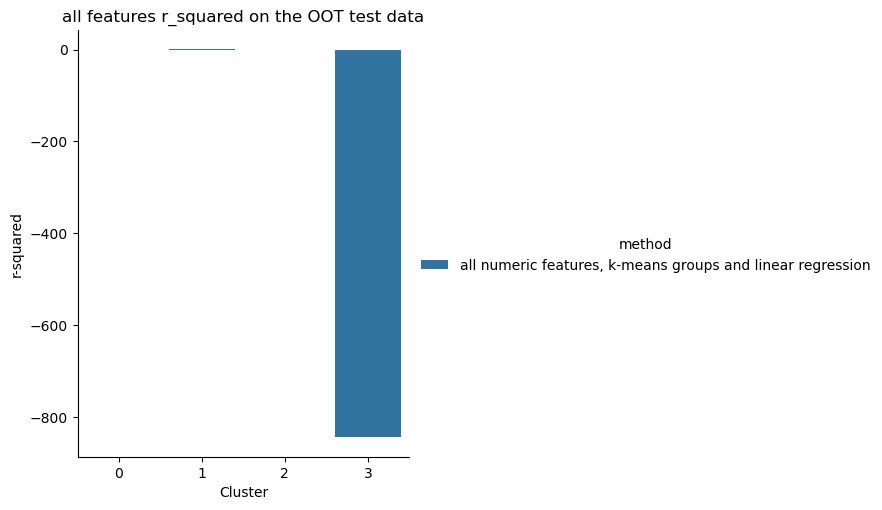

In [41]:
import seaborn as sns


results_plt = sns.catplot(x = "Cluster",       # x variable name
            y = "r-squared",       # y variable name
            hue = "method",  # group variable name
            data = theLinearRegressionFuncAllGrouped_results,     # dataframe to plot
            kind = "bar").set(title="all features r_squared on the OOT test data")

results_plt.figure.savefig("the_resultsrsquared.png")

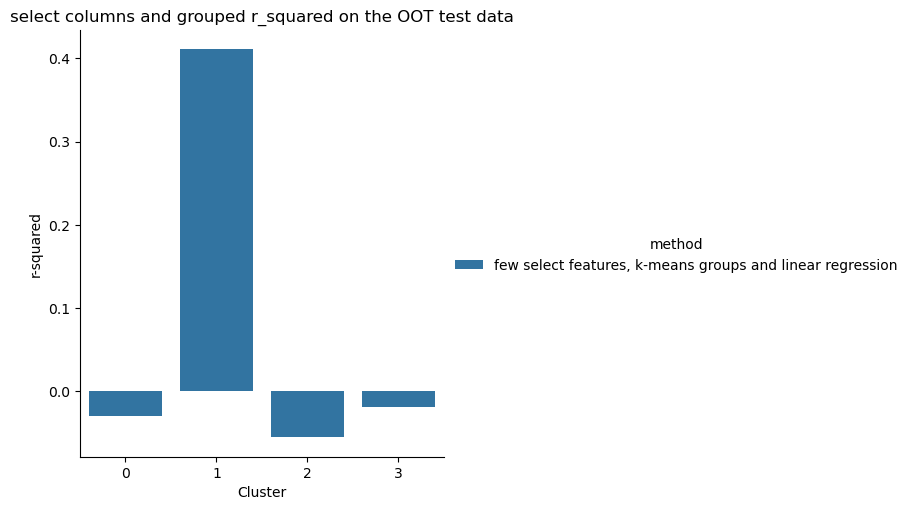

In [42]:
import seaborn as sns


results_plt = sns.catplot(x = "Cluster",       # x variable name
            y = "r-squared",       # y variable name
            hue = "method",  # group variable name
            data = theLinearRegressionFuncFewGrouped_results,     # dataframe to plot
            kind = "bar").set(title="select columns and grouped r_squared on the OOT test data")

results_plt.figure.savefig("setcolumnsgrouped.png")

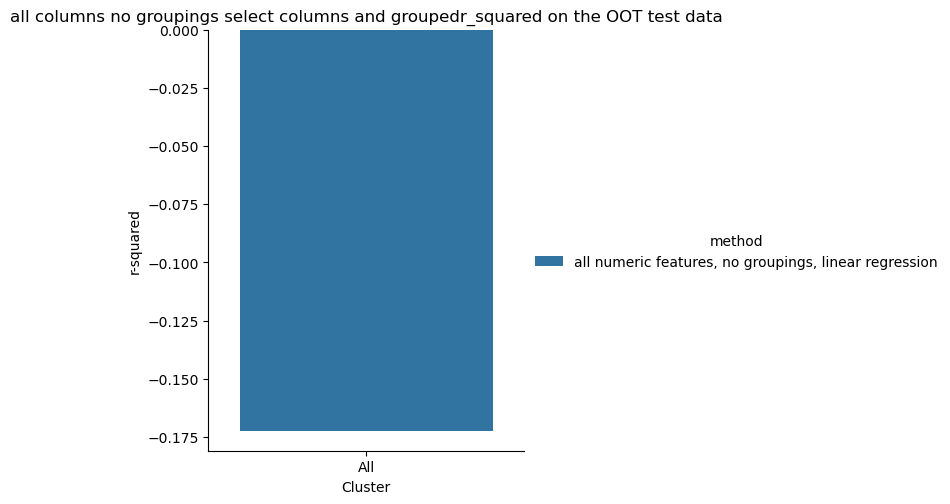

In [43]:
import seaborn as sns


results_plt = sns.catplot(x = "Cluster",       # x variable name
            y = "r-squared",       # y variable name
            hue = "method",  # group variable name
            data = theLinearRegressionFuncAll_results,     # dataframe to plot
            kind = "bar").set(title="all columns no groupings select columns and groupedr_squared on the OOT test data")

results_plt.figure.savefig("allcolumnsnogroups.png")

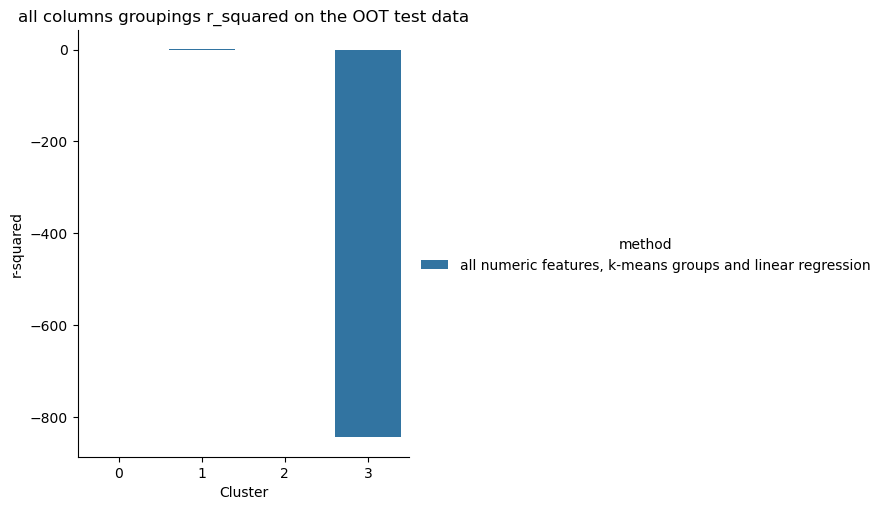

In [44]:
import seaborn as sns


results_plt = sns.catplot(x = "Cluster",       # x variable name
            y = "r-squared",       # y variable name
            hue = "method",  # group variable name
            data = theLinearRegressionFuncAllGrouped_results,     # dataframe to plot
            kind = "bar").set(title="all columns groupings r_squared on the OOT test data")

results_plt.figure.savefig("allcolumnswithgroupings.png")

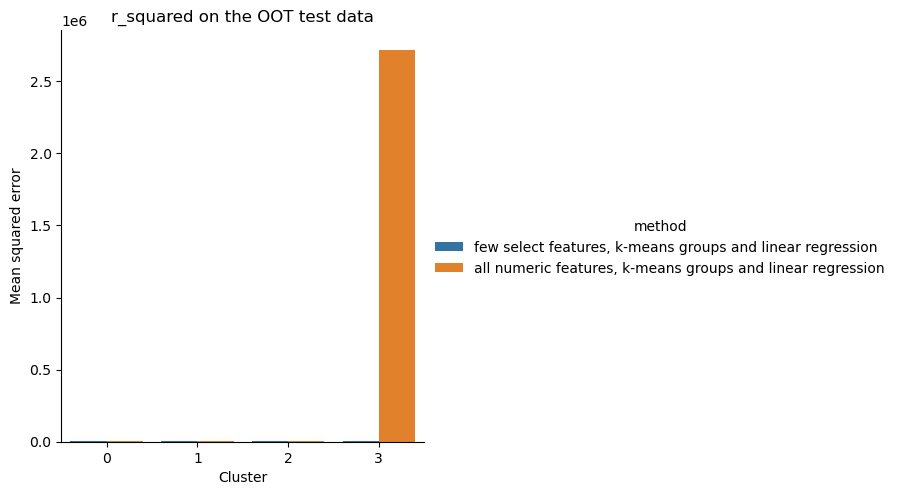

In [45]:
import seaborn as sns


results_plt = sns.catplot(x = "Cluster",       # x variable name
            y = "Mean squared error",       # y variable name
            hue = "method",  # group variable name
            data = the_results,     # dataframe to plot
            kind = "bar").set(title="r_squared on the OOT test data")

results_plt.figure.savefig("the_resultsmeansquareerror.png")

In [46]:
grouped_za_data_df.columns

Index(['main_artist', 'track_name', 'trackAppearanceCount',
       'artistAppearanceCount', 'rank', 'peak_rank', 'previous_rank',
       'weeks_on_chart', 'streams', 'ArtistCount', 'isTopTen',
       'rank difference', 'Max Streams per Song', 'Min Streams per Song',
       'Total Streams per Song', 'Mean Streams per Song',
       'Min Position per Song', 'Artist Song Count',
       'MaxMin Difference Position', 'MaxMin Difference Streams',
       'MaxMin Ratio Position', 'MaxMin Ratio Streams', 'Labels',
       'main_art_track', 'entry rank'],
      dtype='object')

In [47]:
clf = linear_model.PoissonRegressor()


pred_df_one = grouped_za_data_df

y = pred_df_one['Min Position per Song']
X = pred_df_one.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)

clf.fit(X, y)

print(clf.score(X, y))

print(clf.coef_)

print(clf.intercept_)
grouped_za_test_data_df_one = grouped_za_test_data_df
y = grouped_za_test_data_df_one['Min Position per Song']
grouped_za_test_data_df_minusone = grouped_za_test_data_df_one.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)

all_preds = clf.predict(grouped_za_test_data_df_minusone)

print("Mean squared error: %.2f" % mean_squared_error(y, all_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, all_preds))

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4.468006787043089
Mean squared error: 3217.61
Coefficient of determination: -0.00


C:\Users\User\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\User\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)


In [48]:
clf = linear_model.PoissonRegressor()

for alabel in thelabelsmade:
    pred_df_one = grouped_za_data_df[grouped_za_data_df["Labels"] == alabel]
    
    y = pred_df_one['Min Position per Song']
    X = pred_df_one.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)

    clf.fit(X, y)

    print(clf.score(X, y))

    print(clf.coef_)

    print(clf.intercept_)
    grouped_za_test_data_df_one = grouped_za_test_data_df[grouped_za_test_data_df["Labels"] == alabel]
    y = grouped_za_test_data_df_one['Min Position per Song']
    grouped_za_test_data_df_minusone = grouped_za_test_data_df_one.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)

    all_preds = clf.predict(grouped_za_test_data_df_minusone)

    print("Mean squared error: %.2f" % mean_squared_error(y, all_preds))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y, all_preds))

C:\Users\User\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\User\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
C:\Users\User\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\User\anaconda3\lib\site-pa

-2.220446049250313e-16
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4.467077829138427
Mean squared error: 3330.14
Coefficient of determination: -0.00
0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4.487869988292151
Mean squared error: 2883.46
Coefficient of determination: -0.00
0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4.468705149411813


ValueError: Found array with 0 sample(s) (shape=(0, 21)) while a minimum of 1 is required.

In [ ]:
za_data_test_first_time

### Calling Linear Regression on first timers

In [ ]:
some_artists_of_interest = ["6LACK", "9umba", "BNXN fka Buju", "Black Coffee", "Big Zulu"]

groupednum_songs_df, first_track_position_df_relevant = findingtheentrypos(za_data_test_first_time)
groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df = findtheMinMaxMeanStreams(za_data_test_first_time)
groupedpos_streams_df, groupedposmax_streams_df = findtheMinMaxPositions(za_data_test_first_time)
groupeddf, groupeddf_startpos_regress = combinedataframes(groupedmax_streams_df, groupedmin_streams_df, groupedsum_streams_df, groupedmean_streams_df, groupedpos_streams_df, groupedposmax_streams_df, groupednum_songs_df)
filenname = "za_test_first_time"
grouped_za_test_data_first_time_df = thekmeansfunc(za_data_test_first_time_df, groupeddf, groupeddf_startpos_regress, groupby_cols, filenname)
thelabelsmade_first_time_test = grouped_za_test_data_first_time_df["Labels"].unique().tolist()

In [ ]:
# model = theLinearRegressionFuncFewGrouped(grouped_za_data_df, thelabelsmade)

# y = grouped_za_test_data_first_time_df['Min Position per Song']
# grouped_za_test_data_first_time_df_minus = grouped_za_test_data_first_time_df.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)
# all_preds = model.predict(grouped_za_test_data_first_time_df_minus)

# print("Mean squared error: %.2f" % mean_squared_error(y, all_preds))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, all_preds))

model = theLinearRegressionFuncAllGrouped(grouped_za_data_df, grouped_za_test_data_df, thelabelsmade)

y = grouped_za_test_data_first_time_df['Min Position per Song']
grouped_za_test_data_first_time_df_minus = grouped_za_test_data_first_time_df.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)
all_preds = model.predict(grouped_za_test_data_first_time_df_minus)


print("Mean squared error: %.2f" % mean_squared_error(y, all_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, all_preds))



# model = theLinearRegressionFuncAll(grouped_za_data_df, grouped_za_test_data_df)

# y = grouped_za_test_data_first_time_df['Min Position per Song']
# grouped_za_test_data_first_time_df_minus = grouped_za_test_data_first_time_df.drop(["main_artist", "track_name", "main_art_track",'Min Position per Song'], axis=1)
# all_preds = model.predict(grouped_za_test_data_first_time_df_minus)


# print("Mean squared error: %.2f" % mean_squared_error(y, all_preds))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y, all_preds))

### Descriptions

In [ ]:
for thelabel in labels_kmeans:
    number_ones = grouped_za_data_df[grouped_za_data_df['Labels'] == thelabel]
    print(number_ones.shape)
    x = number_ones['entry rank'].tolist()
    y = number_ones['Min Position per Song'].tolist()

    plt.title(thelabel)
    plt.xlabel('entry rank')
    plt.ylabel('Min Position per Song')
    plt.scatter(x, y)
    plt.show()

In [ ]:
the_labels_more = grouped_za_data_df["Labels"].unique().tolist()

In [ ]:
for alabel in the_labels_more:
    kmeans_df_zero = grouped_za_data_df[grouped_za_data_df["Labels"] == alabel]
    description = kmeans_df_zero.describe()

number of artists in label
number of top 10 songs in label


### do it at an artist level but maybe in groups so that you do not need a lot of data for everyone.

In [ ]:
# for theartist in some_artists_of_interest:
#     number_ones = groupeddf_startpos_regress[groupeddf_startpos_regress['main_artist'] == theartist]

#     x = number_ones['entry rank'].tolist()
#     y = number_ones['Min Position per Song'].tolist()

#     plt.scatter(x, y)
#     plt.title(theartist)
#     plt.xlabel('entry rank')
#     plt.ylabel('Min Position per Song')
#     plt.show()

In [ ]:
# number_ones = groupeddf_startpos_regress[groupeddf_startpos_regress['main_artist'] == "salem ilese"]
# print(number_ones.shape)
# x = number_ones['entry rank'].tolist()
# y = number_ones['Min Position per Song'].tolist()

# plt.scatter(x, y)
# plt.show()